#0.0 IMPORTS

In [1]:
pip install boruta

In [2]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
import scipy.stats         as stats
import sklearn.metrics     as metrics

import warnings
import random
import requests
import json
import datetime
import math
import pickle


from sklearn.preprocessing     import RobustScaler,MinMaxScaler
from tabulate                  import tabulate
from boruta                    import BorutaPy
from IPython.display           import Image
from sklearn.preprocessing     import LabelEncoder,RobustScaler,MinMaxScaler
from sklearn.model_selection   import train_test_split
from sklearn.metrics           import precision_score, recall_score, f1_score
from sklearn.ensemble          import RandomForestRegressor,RandomForestClassifier
from sklearn.dummy             import DummyClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.neighbors         import KNeighborsClassifier 
from sklearn.naive_bayes       import GaussianNB,BernoulliNB
from sklearn.svm               import SVC
from sklearn.ensemble          import GradientBoostingClassifier
from sklearn.tree              import DecisionTreeClassifier
from sklearn.metrics           import roc_curve, auc
from sklearn.metrics           import accuracy_score
from sklearn.model_selection   import cross_val_predict
from sklearn.metrics           import confusion_matrix
from sklearn.model_selection   import StratifiedKFold
from sklearn.metrics           import precision_recall_curve
from sklearn.metrics           import recall_score

##0.1 Helper Functions

In [3]:
def model_perform(y_test,yhat,model_name):

  data=pd.DataFrame({       'model Name':   model_name, 
                            'accuracy'  :   accuracy_score(y_test, yhat),                                                                                                  
                            'precision' :   precision_score(y_test,yhat),
                            'recall'    :   recall_score(y_test,yhat, average='macro'),
                            'f1 score'  :   f1_score(y_test,yhat)                     
                                                                   },index=[0])
  return data


def cross_validation(data,kfold,model_name,model):
  
  accuracy_list=[]
  precision_list=[]
  recall_list=[]
  f1_score_list=[]
  
  
  fim=[]
  inicio=[]  
  razao=data.index.max()/kfold
  for i in range(1,kfold+1):
    fim.append(round(razao*i,2))
    inicio.append(round((razao*i)-razao,2))

  for k in range(0,kfold):

    #Start and end for validation
    validation_start=inicio[k]
    validation_end=fim[k]

    #Filtering in dataset
    aux=data[(data.index>=validation_start) & (data.index<=validation_end)]
    training=data.drop(aux.index,axis=0)
    validation=data[(data.index>=validation_start) & (data.index<=validation_end)]


    #Training and validation dataset
    #Training
    xtraining=training.drop(['fraude'],axis=1)
    ytraining=training['fraude']

    #Validation
    xvalidation=validation.drop(['fraude'],axis=1)
    yvalidation=validation['fraude']

    #model
    m=model.fit(xtraining,ytraining)

    #prediction
    yhat=m.predict(xvalidation)

    performaces=model_perform(yvalidation,yhat,model_name)
    
    #performance of each KFold iteration
    accuracy_list.append(performaces['accuracy'])
    precision_list.append(performaces['precision'])
    recall_list.append(performaces['recall'])
    f1_score_list.append(performaces['f1 score'])
    
    


  return pd.DataFrame({ 'Model name':               model_name,  
                        'accuracy CV':              np.round(np.mean(accuracy_list),2).astype(str)+ '+/-' + np.round(np.std(accuracy_list),2).astype(str),                    
                        'precision CV':             np.round(np.mean(precision_list),2).astype(str)+ '+/-' + np.round(np.std(precision_list),2).astype(str),
                        'recall CV':                np.round(np.mean(recall_list),2).astype(str)+ '+/-' + np.round(np.std(recall_list),2).astype(str),
                        'f1 score CV':              np.round(np.mean(f1_score_list),2).astype(str)+ '+/-' + np.round(np.std(f1_score_list),2).astype(str)
                        
                        
                       
                        },index=[0])
  


def boruta (x_train,y_train):
  
  #Training and test dataset for Boruta
  X_train_boruta = x_train.values
  Y_train_boruta = y_train.values.ravel()

  #Define RandomForestRegressor
  rf=RandomForestRegressor(n_jobs=-1)

  #Define Boruta
  boruta=BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(X_train_boruta,Y_train_boruta)  
  
  return boruta
  


def best_features(boruta,x_train):

  cols_selected=boruta.support_.tolist()

  #best features
  x_train_fs=x_train
  cols_selected_boruta=x_train_fs.iloc[:,cols_selected].columns.to_list()

  #not selected boruta
  cols_not_selected_boruta=list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))

  return cols_selected_boruta


#rescaling
def rescaling(poucos_outliers,muitos_outliers,data):
  
  rs=RobustScaler()
  mms=MinMaxScaler()

  #poucos_outliers
  for i in range(0,len(poucos_outliers)):
    data[poucos_outliers[i]]=mms.fit_transform(data[[poucos_outliers[i]]].values)   

  #muitos_outliers
  for i in range(0,len(muitos_outliers)):
    data[muitos_outliers[i]]=rs.fit_transform(data[[muitos_outliers[i]]].values)     

  return data


def correlacao_features_numericas(numericos,data):

  columns=numericos.columns
  aux=data[columns]

  correlation=aux.corr(method='pearson')
  ax=sns.heatmap(correlation,annot=True);
  ax.figure.set_size_inches(18,10)
  ax.set_title('Correlação entre features numéricas',fontsize=14)

  return ax


def correlacao_categorica(data):

  #selecao
  a=data.select_dtypes(include='object')

  #lista 1 , todas correlacoes
  columns=a.columns
  lista=[]
  for i2 in range(0,len(columns)):
    for i in range(0,len(columns)):
      lista.append(cramer_v(a[columns[i2]],a[columns[i]]))

  #lista 2 , correlacoes por features
  lista2=[]
  n_features=len(columns)
  for i in range(0,n_features):

    a=n_features*i
    b=n_features*(i+1)

    lista2.append(lista[a:b])
  
  return lista2

  
def cramer_v(x,y):
  
  cm=pd.crosstab(x, y).to_numpy()
  n=cm.sum()
  r,k=cm.shape
  chi2=stats.chi2_contingency(cm)[0]
  chi2corr=max(0,chi2-(k-1)*(r-1)/(n-1))
  kcorr=k-(k-1)**2/(n-1)
  rcorr=r-(r-1)**2/(n-1)

  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


def estatistica_descritiva(data):

  #selecao
  num_attributes=data.select_dtypes(include=['int64','float64'])

  #Central tendency=mean,median
  ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
  ct2=pd.DataFrame(num_attributes.apply(np.median)).T

  # Dispersion=std,min,max,range,skew,kurtosis
  d1=pd.DataFrame(num_attributes.apply(np.std)).T
  d2=pd.DataFrame(num_attributes.apply(min)).T
  d3=pd.DataFrame(num_attributes.apply(max)).T
  d4=pd.DataFrame(num_attributes.apply(lambda x:x.mean()-x.min())).T
  d5=pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
  d6=pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

  #Concatenate
  aux=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()  
  aux.columns=(['attributes','min','max','range','mean','median','std','skew','kurtosis']) 

  return aux


def curva_roc(y_test,yhat):
  
  fpr, tpr, threshold = metrics.roc_curve(y_test, yhat)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  return plt.show()



def calcula_limite_superior_e_inferior(data):

  q1=data.quantile(0.25)
  q3=data.quantile(0.75)
  
  iiq=q3-q1

  limite_inferior=q1-1.5*iiq
  limite_superior=q3+1.5*iiq
  
  return [limite_superior,limite_inferior]

##0.2 Loading Data

In [4]:
df_raw=pd.read_csv('/content/PS_20174392719_1491204439457_log.csv')
df_raw.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df_test_deploy=df_raw[df_raw.index<1000]

# 1.0 PASSO 1 - DESCRIPTION OF THE DATA

In [6]:
#copia do dataframe
df1=df_raw.copy()

##1.1 Rename Columns

In [7]:
columns={   'step':'etapa','type':'tipos','amount':'montante','nameOrig':'remetente',
            'oldbalanceOrg':'saldo_inicial_remetente','newbalanceOrig':'saldo_atual_remetente',
            'nameDest':'destinatario','oldbalanceDest':'saldo_inicial_destinatario',
            'newbalanceDest':'saldo_atual_destinatario','isFraud':'fraude','isFlaggedFraud':'fraude_sinalizada'}
df1=df1.rename(columns=columns)
df1.head()

,etapa,tipos,montante,remetente,saldo_inicial_remetente,saldo_atual_remetente,destinatario,saldo_inicial_destinatario,saldo_atual_destinatario,fraude,fraude_sinalizada
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


##1.2 Data Dimensions

In [8]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 6362620
Number of cols: 11


##1.3 Data Types

In [9]:
df1.dtypes

etapa                           int64
tipos                          object
montante                      float64
remetente                      object
saldo_inicial_remetente       float64
saldo_atual_remetente         float64
destinatario                   object
saldo_inicial_destinatario    float64
saldo_atual_destinatario      float64
fraude                          int64
fraude_sinalizada               int64
dtype: object

##1.4 Check NA

In [10]:
df1.isna().sum()

etapa                         0
tipos                         0
montante                      0
remetente                     0
saldo_inicial_remetente       0
saldo_atual_remetente         0
destinatario                  0
saldo_inicial_destinatario    0
saldo_atual_destinatario      0
fraude                        0
fraude_sinalizada             0
dtype: int64

##1.5 Fillout NA

In [11]:
df1=df1[df1['destinatario'].isna()==False]

##1.6 Change types

In [12]:
df1['fraude']=df1['fraude'].astype(str)
df1['fraude_sinalizada']=df1['fraude_sinalizada'].astype(str)

##1.7 Descriptive Statistical

In [13]:
num_attributes=df1.select_dtypes(include=['int64','float64'])
cat_attributes=df1.select_dtypes(include=['object'])

###1.7.1 Numerical Attributes

In [14]:
estatistica_descritiva(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,etapa,1.0,7.430000e+02,2.423972e+02,2.433972e+02,239.000,1.423320e+02,0.375177,0.329071
1,montante,0.0,9.244552e+07,1.798619e+05,1.798619e+05,74871.940,6.038582e+05,30.993949,1797.956705
2,saldo_inicial_remetente,0.0,5.958504e+07,8.338831e+05,8.338831e+05,14208.000,2.888242e+06,5.249136,32.964879
3,saldo_atual_remetente,0.0,4.958504e+07,8.551137e+05,8.551137e+05,0.000,2.924048e+06,5.176884,32.066985
4,saldo_inicial_destinatario,0.0,3.560159e+08,1.100702e+06,1.100702e+06,132705.665,3.399180e+06,19.921758,948.674125
5,saldo_atual_destinatario,0.0,3.561793e+08,1.224996e+06,1.224996e+06,214661.440,3.674129e+06,19.352302,862.156508


###1.7.2 Categorical attributes


In [15]:
#numero de classes por feature
cat_attributes.apply(lambda x: x.unique().shape[0])

tipos                      5
remetente            6353307
destinatario         2722362
fraude                     2
fraude_sinalizada          2
dtype: int64

Text(0.5, 1.0, 'Número de fraudes por tipos de transferência.')

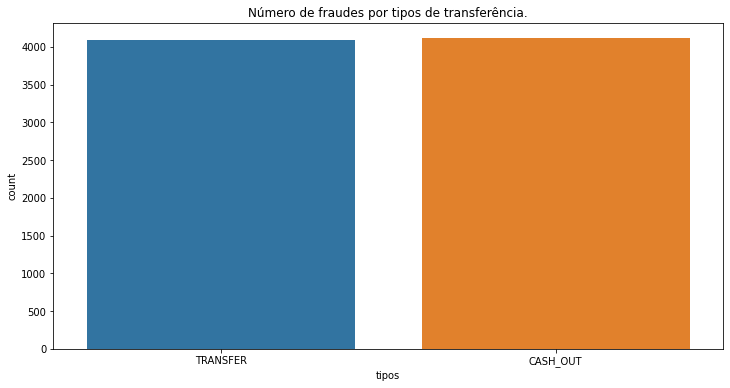

In [16]:
#plot das features categoricas em relacao a variavel resposta
fraude=df1[df1['fraude']=='1']
ax=sns.countplot(x='tipos', data=fraude)
ax.figure.set_size_inches(12,6)
ax.set_title('Número de fraudes por tipos de transferência.')

#2.0 PASSO 2 - FEATURE ENGINEERING

In [17]:
#copia do dataframe
df2=df1.copy()

##2.1 Mapa mental de Hipoteses

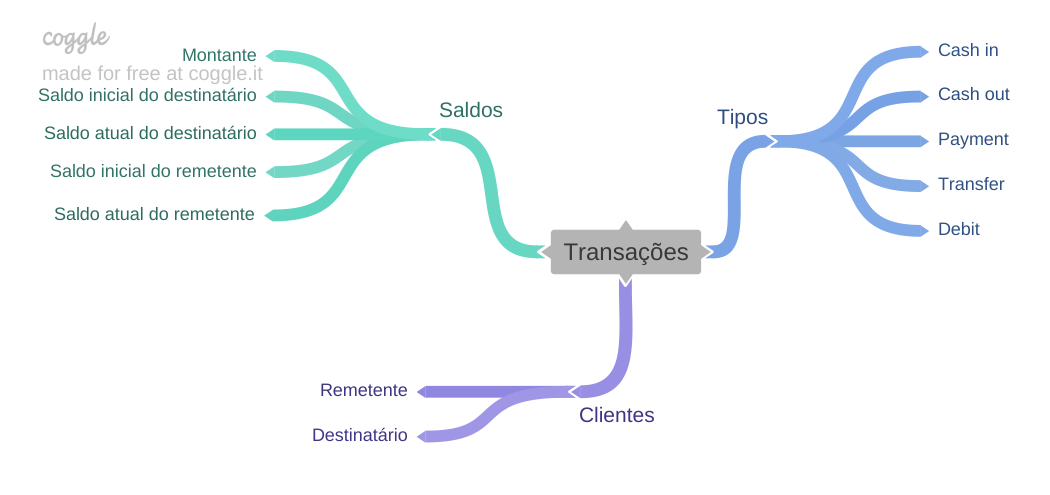

In [18]:
Image('/content/Transacoes.png')

##2.1 Criação das hipoteses

### 2.1.1 Hipoteses Saldos

**1.** Quanto maior o saldo inicial do destinatário, maior é a chance de fraude.

**2.** Quanto maior o saldo atual do destinatário, maior é a chance de fraude.

 **3.** Quanto maior o saldo inicial do remetente , maior é a chance de fraude.

**4.** Quanto maior o saldo atual do remetente , maior é a chance de fraude.

### 2.1.2 Hipoteses Clientes

**1.** Há maior chance de fraude quando o nome do remetente for inconsistente.

### 2.1.3 Hipoteses Tipos

**1.** Há maior chance de fraude , quando as transações são dos tipos TRANSFER e CASH OUT.

### 2.1.4 Hipoteses Outros

**1.** Quanto maior  a etapa de medição, maior é a chance de fraude.

##2.2 Lista final de hipoteses

**H1-**. Quanto maior o saldo inicial do destinatário, maior é a chance de fraude.

**H2-**. Quanto maior o saldo atual do destinatário, maior é a chance de fraude.

**H3-**. Quanto maior o saldo inicial do remetente , maior é a chance de fraude.

**H4-**. Quanto maior o saldo atual do destinatário , maior é a chance de fraude.

**H5-**. Quanto maior o valor do montante , maior é a chance de fraude.


**H6-**. Quanto maior  a etapa de medição, maior é a chance de fraude.

##2.3 Feature Engineering

In [19]:
#alerta_montante
df2['alerta_montante']=df2['montante']
df2['alerta_montante']=df2['alerta_montante'].apply(lambda x: '1' if x>300000 else '0')

#alerta_etapa
df2['alerta_etapa']=df2['etapa']
df2['alerta_etapa']=df2['alerta_etapa'].apply(lambda x: '1' if x>367 else '0')

#alerta_saldo_inicial_remetente
df2['alerta_saldo_inicial_remetente']=df2['saldo_inicial_remetente']
df2['alerta_saldo_inicial_remetente']=df2['alerta_saldo_inicial_remetente'].apply(lambda x: '1' if x>1500000 else '0')

#3.0. PASSO 3 - VARIABLES FILTERING

In [20]:
#copia do dataframe
df3=df2.copy()

##3.1. Line Filtering

In [21]:
df3['fraude']=df3['fraude'].apply(lambda x: 'sim' if x=='1' else 'nao')

##3.2. Column selection

#4.0. PASSO 4 - EXPLORATORY DATA ANALYSIS

In [22]:
#copia do dataframe
df4=df3.copy()

## 4.1 Univariate Analysis

###4.1.1. Response Variable

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


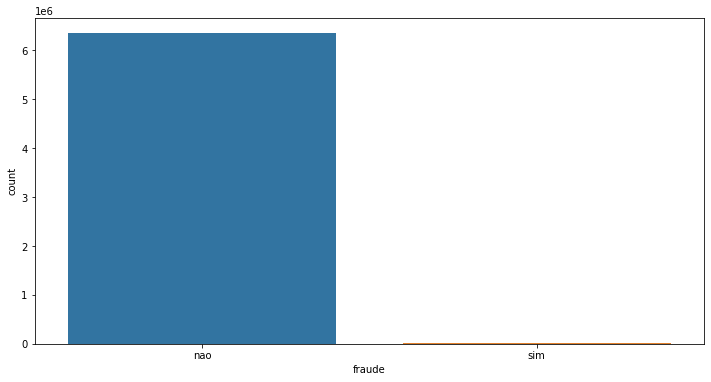

In [23]:
ax=sns.countplot(df4['fraude'])
ax.figure.set_size_inches(12,6)

###4.1.2. Numerical Variable

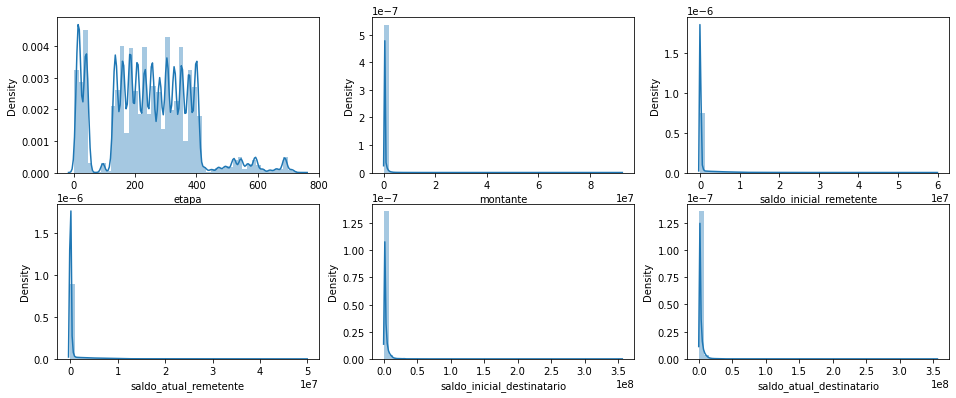

In [24]:
# num_attributes and cat_attributes
num_attributes=df4[['etapa','montante','saldo_inicial_remetente','saldo_atual_remetente',
                    'saldo_inicial_destinatario','saldo_atual_destinatario']]
cat_attributes=df4[['tipos','destinatario','remetente','fraude','fraude_sinalizada']]

#plot das features numericas
warnings.filterwarnings('ignore')

lista=num_attributes.columns

for i in range(0,len(lista)):

  plt.subplot(len(lista),3,i+1)
  ax=sns.distplot(df4[lista[i]])  
  ax.figure.set_size_inches(16,20)

###4.1.3. Categorical Variable

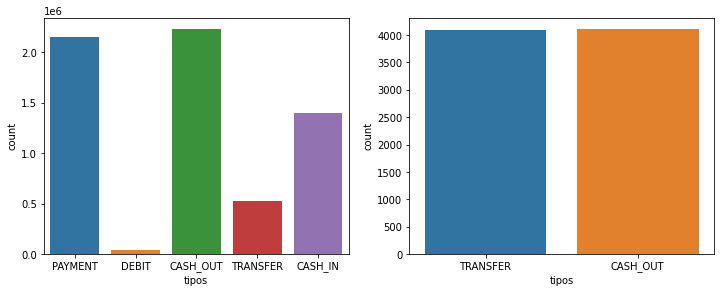

In [25]:
#separados por fraudes e dados normais
fraudes=cat_attributes[cat_attributes['fraude']=='sim']
normais=cat_attributes[cat_attributes['fraude']=='nao']

#tipos
plt.subplot(4,2,1)
ax=sns.countplot(x='tipos', data=normais)
ax.figure.set_size_inches(12,20)
plt.subplot(4,2,2)
ax=sns.countplot(x='tipos', data=fraudes)

## 4.2 Bivariate Analysis

### ***H1***. Quanto maior o saldo inicial do destinatário, maior é a chance de fraude.(FALSE)

In [26]:
fraudes=df4[df4['fraude']=='sim']
normais=df4[df4['fraude']=='nao']

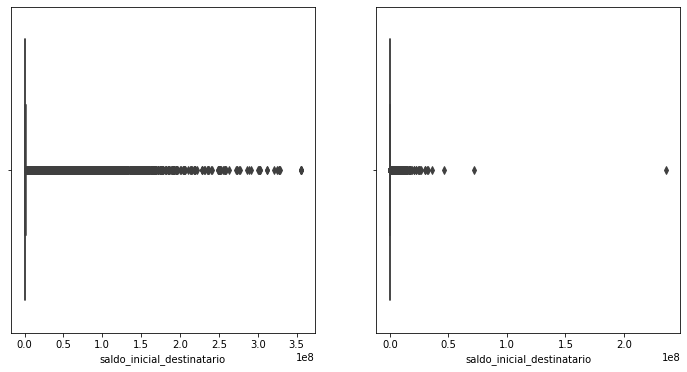

In [27]:
plt.subplot(1,2,1)
ax=sns.boxplot(x='saldo_inicial_destinatario', data=normais)
ax.figure.set_size_inches(12,6)
plt.subplot(1,2,2)
ax=sns.boxplot(x='saldo_inicial_destinatario', data=fraudes)

In [28]:
media_saldo_inicial_destinatario_fraudes=fraudes['saldo_inicial_destinatario'].mean()
media_saldo_inicial_destinatario_normais=normais['saldo_inicial_destinatario'].mean()
razao=media_saldo_inicial_destinatario_fraudes/media_saldo_inicial_destinatario_normais
razao

0.49413410589970663

In [29]:
print('A média do saldo em transações fraudulentas é 2x menor, ou seja em fraudes o saldo tende a ser menor do que {}'.format(media_saldo_inicial_destinatario_fraudes))

A média do saldo em transações fraudulentas é 2x menor, ou seja em fraudes o saldo tende a ser menor do que 544249.6190746377


### ***H2***. Quanto maior o saldo atual do destinatário, maior é a chance de fraude.(FALSE)

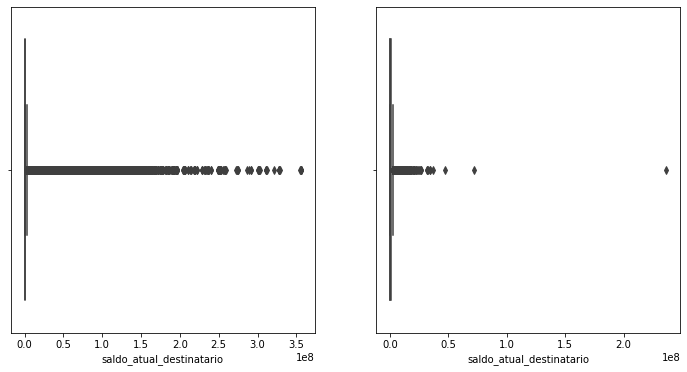

In [30]:
plt.subplot(1,2,1)
ax=sns.boxplot(x='saldo_atual_destinatario', data=normais)
ax.figure.set_size_inches(12,6)
plt.subplot(1,2,2)
ax=sns.boxplot(x='saldo_atual_destinatario', data=fraudes)

In [31]:
media_saldo_atual_destinatario_fraudes=fraudes['saldo_atual_destinatario'].mean()
media_saldo_atual_destinatario_normais=normais['saldo_atual_destinatario'].mean()
razao=media_saldo_atual_destinatario_fraudes/media_saldo_atual_destinatario_normais
razao

1.0447226580951414

### ***H3***. Quanto maior o saldo inicial do remetente , maior é a chance de fraude. (TRUE)

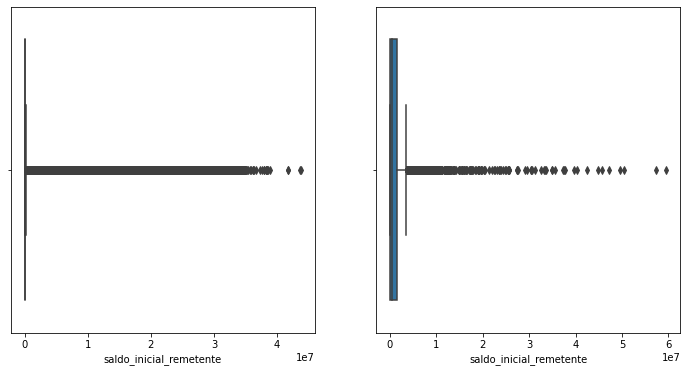

In [32]:
plt.subplot(1,2,1)
ax=sns.boxplot(x='saldo_inicial_remetente', data=normais)
ax.figure.set_size_inches(12,6)
plt.subplot(1,2,2)
ax=sns.boxplot(x='saldo_inicial_remetente', data=fraudes)

In [33]:
media_saldo_inicial_remetente_fraudes=fraudes['saldo_inicial_remetente'].mean()
media_saldo_inicial_remetente_normais=normais['saldo_inicial_remetente'].mean()
razao=media_saldo_inicial_remetente_fraudes/media_saldo_inicial_remetente_normais
razao

1.980800592585633

In [34]:
media_saldo_inicial_remetente_fraudes

1649667.6057116783

### ***H4***. Quanto maior o saldo atual do remetente , maior é a chance de fraude. (FALSE)

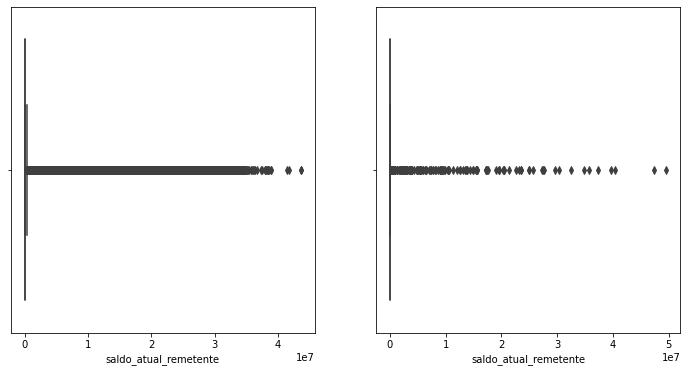

In [35]:
plt.subplot(1,2,1)
ax=sns.boxplot(x='saldo_atual_remetente', data=normais)
ax.figure.set_size_inches(12,6)
plt.subplot(1,2,2)
ax=sns.boxplot(x='saldo_atual_remetente', data=fraudes)

In [36]:
media_saldo_atual_remetente_fraudes=fraudes['saldo_atual_remetente'].mean()
media_saldo_atual_remetente_normais=normais['saldo_atual_remetente'].mean()
razao=media_saldo_atual_remetente_fraudes/media_saldo_inicial_remetente_normais
razao

0.23101104600140188

### ***H5***. Quanto maior o valor do montante , maior é a chance de fraude. (TRUE)


Text(0.5, 1.0, 'Fraude')

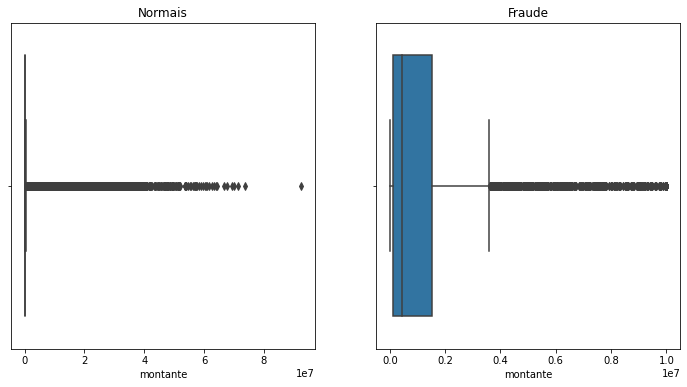

In [37]:
plt.subplot(1,2,1)
ax=sns.boxplot(x='montante', data=normais)
ax.set_title('Normais')
ax.figure.set_size_inches(12,6)
plt.subplot(1,2,2)
ax=sns.boxplot(x='montante', data=fraudes)
ax.set_title('Fraude')

In [38]:
media_montante_fraudes=fraudes['montante'].mean()
media_montante_normais=normais['montante'].mean()
razao=media_montante_fraudes/media_montante_normais
razao

8.23788815409209

In [39]:
q1=fraudes['montante'].quantile(0.25)
q3=fraudes['montante'].quantile(0.75)

Q1=normais['montante'].quantile(0.25)
Q3=normais['montante'].quantile(0.75)

print('O valor do montante fraudulento está entre R$ {} e  R$ {}.'.format(q1,q3))
print('O valor do montante sem fraude está entre R$ {} e  R$ {}.'.format(Q1,Q3))

O valor do montante fraudulento está entre R$ 127091.33 e  R$ 1517771.48.
O valor do montante sem fraude está entre R$ 13368.395 e  R$ 208364.76.


### ***H6***. Quanto maior  a etapa de medição, maior é a chance de fraude. (TRUE)

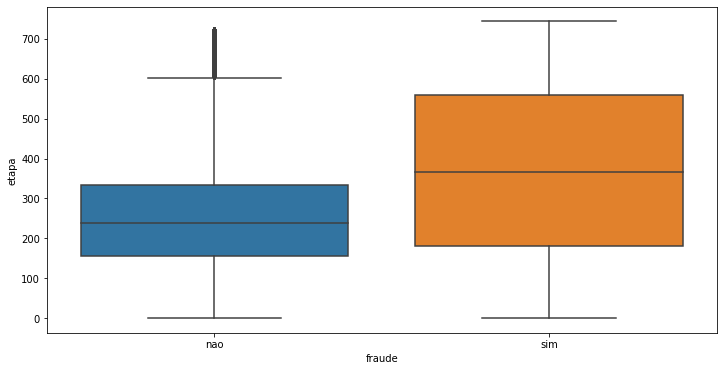

In [40]:
ax=sns.boxplot(x='fraude',y='etapa',data=df4)
ax.figure.set_size_inches(12,6)

In [41]:
df4[df4['fraude']=='sim']['etapa'].quantile(0.5)

367.0

### 4.2.1 Summary of hypotheses

In [42]:
#dataframe com o resumo das hipoteses
tab=[['Hipoteses','conclusao','Relevancia'],
     ['H1','Falsa','Media'],
     ['H2','Falsa','Baixa'],
     ['H3','Verdadeira','Alta'],
     ['H4','Falsa','Baixa'],
     ['H5','Verdadeira','Alta'],
     ['H6','Verdadeira','Media']]

print(tabulate(tab,headers='firstrow'))

Hipoteses    conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Media
H2           Falsa        Baixa
H3           Verdadeira   Alta
H4           Falsa        Baixa
H5           Verdadeira   Alta
H6           Verdadeira   Media


## 4.3 Multivariate Analysis

###4.3.1. Numerical Atributes

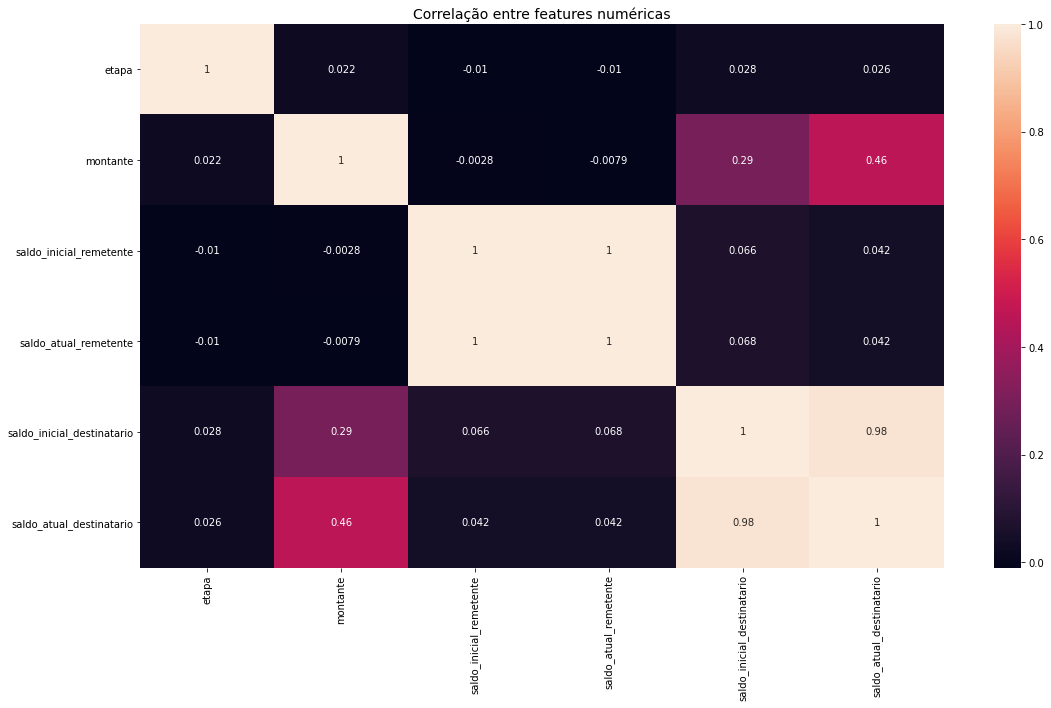

In [43]:
#grafico de correlacao
correlacao_features_numericas(num_attributes,df4)

###4.3.2. Categorical Atributes

In [45]:
lista=correlacao_categorica(df4[df4.index<10000])

d=pd.DataFrame({'tipos':                           lista[0],
                'remetente':                       lista[1],
                'destinatario':                    lista[2],
                'fraude':                          lista[3],
                'fraude_sinalizada':               lista[4], 
                'alerta_montante':                 lista[5],
                'alerta_etapa':                    lista[6],
                'alerta_saldo_inicial_remetente':  lista[7]             
                })

d=d.set_index(d.columns)

d.head()

,tipos,remetente,destinatario,fraude,fraude_sinalizada,alerta_montante,alerta_etapa,alerta_saldo_inicial_remetente
tipos,1.000200,inf,0.663502,0.156185,NaN,0.479162,NaN,0.838592
remetente,inf,inf,inf,inf,NaN,inf,NaN,inf
destinatario,0.663502,inf,1.665836,0.768233,NaN,0.582777,NaN,0.616771
fraude,0.156185,inf,0.768233,0.992646,NaN,0.018320,NaN,0.020884
fraude_sinalizada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#5.0. PASSO 5 - DATA PREPARATION

In [46]:
#copia do dataframe
df5=df4.copy()

##5.1. Rescaling

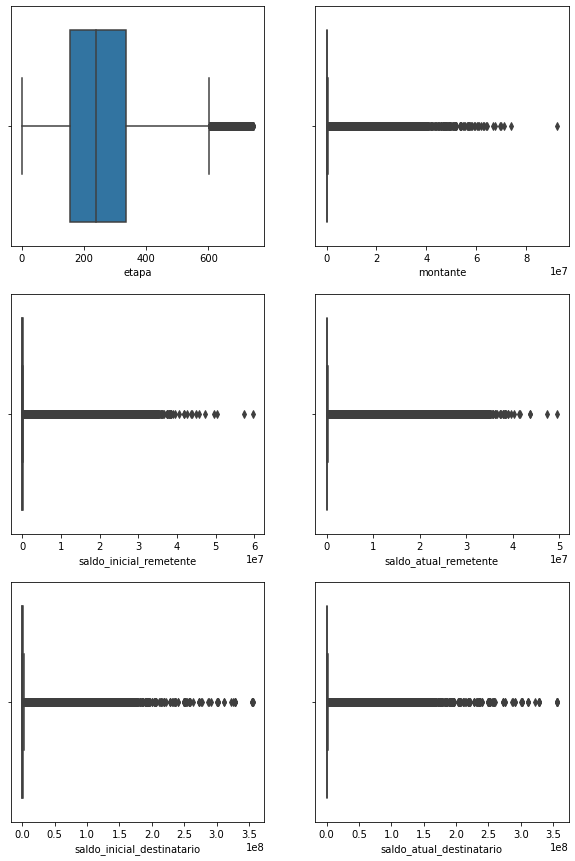

In [47]:
#num_attributes e cat_attributes
num_attributes=df5.select_dtypes(include=['int64','float64'])
cat_attributes=df5.select_dtypes(include='object')

#grafico para verificacao de outliers
columns=num_attributes.columns

for i in range(0,len(columns)):

  plt.subplot(3,2,i+1)
  ax=sns.boxplot(num_attributes[columns[i]])
  ax.figure.set_size_inches(10,15)

In [48]:
#outliers
muitos_outliers=['saldo_inicial_destinatario','saldo_atual_destinatario',
                 'saldo_inicial_remetente','saldo_atual_remetente']
poucos_outliers=['etapa']

#rescaling
df5=rescaling(poucos_outliers,muitos_outliers,df5)

## 5.2. Transformation

###5.3.1. Encoding

In [49]:
#Label Encoding
#tipos
le=LabelEncoder()
df5['tipos']=le.fit_transform(df5['tipos'])

#cliente_remetente
df5['remetente']=le.fit_transform(df5['remetente'])

#cliente_destinatario
df5['destinatario']=le.fit_transform(df5['destinatario'])

#fraude
df5['fraude']=le.fit_transform(df5['fraude'])


#One Hot Encoding
#fraude_sinalizada
df5=pd.get_dummies(df5,prefix=['fraude_sinalizada'],columns=['fraude_sinalizada'])

#alerta_montante
df5=pd.get_dummies(df5,prefix=['alerta_montante'],columns=['alerta_montante'])

#alerta_etapa
df5=pd.get_dummies(df5,prefix=['alerta_etapa'],columns=['alerta_etapa'])

#alerta_saldo_inicial_remetente
df5=pd.get_dummies(df5,prefix=['alerta_saldo_inicial_remetente'],columns=['alerta_saldo_inicial_remetente'])

In [50]:
#transformation
#montante
df5['montante']=np.log1p(df5['montante'])

#6.0. PASSO 6 - FEATURE SELECTION

In [51]:
#copia do dataframe
df6=df5.copy()

##6.1. Split dataframe into training and test dataset.

In [52]:
#df_test_deploy
df_test_deploy=df6[df6.index<1000]

#split train and test
df6=df6[df6.index>=1000]
y=df6['fraude']
x=df6.drop(['fraude'],axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=2811)

##6.2. Boruta as feature selector


In [53]:
boruta=boruta(x_train,y_train)

'boruta=boruta(x_train,y_train)'

###6.2.1. Best Features from Boruta

In [54]:
best_features(boruta,x_train)

'best_features(boruta,x_train)'

##6.3. Manual Feature selection


In [55]:
cols_selected_boruta=['etapa','tipos','montante','saldo_inicial_remetente',
                      'saldo_atual_remetente','destinatario','saldo_atual_destinatario']

#Columns to add
feat_to_add=['fraude']
cols_selected_boruta_full=cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

#7.0. PASSO 7 - MACHINE LEARNING MODELLING

In [56]:
#copia do dataframe
df7=df6[cols_selected_boruta_full].copy()

x_train=x_train[cols_selected_boruta]
x_test=x_test[cols_selected_boruta]

##7.1. Base Line

In [105]:
#model
dc = DummyClassifier()
dc_train=dc.fit(x_train,y_train)

#predict
yhat_dc=dc_train.predict(x_test)

#performance
dc_result=model_perform(y_test,yhat_dc,'baseline')
dc_result

,model Name,accuracy,precision,recall,f1 score
0,baseline,0.997375,0.000796,0.499741,0.000798


###7.1.1. Base Line - Cross validation

In [59]:
dc_result_cv=cross_validation(df7,5,'baseline',dc)
dc_result_cv

"dc_result_cv=cross_validation(df7,5,'baseline',dc)\ndc_result_cv"

##7.2. Random Forest Classifier


In [60]:
#model
rfc=RandomForestClassifier(max_depth=2, random_state=0)
rfc_train=rfc.fit(x_train,y_train)

#predict
yhat_rfc=rfc_train.predict(x_test)

#performance
rfc_result=model_perform(y_test,yhat_rfc,'RandomForestClassifier')
rfc_result

"#model\nrfc=RandomForestClassifier(max_depth=2, random_state=0)\nrfc_train=rfc.fit(x_train,y_train)\n\n#predict\nyhat_rfc=rfc_train.predict(x_test)\n\n#performance\nrfc_result=model_perform(y_test,yhat_rfc,'RandomForestClassifier')\nrfc_result"

###7.2.1. Random Forest Classifier-Cross validation

In [62]:
rfc_result_cv=cross_validation(df7,5,'RandomForestClassifier',rfc)
rfc_result_cv

"rfc_result_cv=cross_validation(df7,5,'RandomForestClassifier',rfc)\nrfc_result_cv"

##7.3. Logistic Regression

In [63]:
#model
lr= LogisticRegression(random_state=0)
lr_train=lr.fit(x_train,y_train)

#predict
yhat_lr=lr_train.predict(x_test)

#performance
lr_result=model_perform(y_test,yhat_lr,'Logistic Regression')
lr_result

"#model\nlr= LogisticRegression(random_state=0)\nlr_train=lr.fit(x_train,y_train)\n\n#predict\nyhat_lr=lr_train.predict(x_test)\n\n#performance\nlr_result=model_perform(y_test,yhat_lr,'Logistic Regression')\nlr_result"

###7.3.1 Logistic Regression cross validation

In [65]:
lr_result_cv=cross_validation(df7,5,'Logistic Regression',lr)
lr_result_cv

"lr_result_cv=cross_validation(df7,5,'Logistic Regression',lr)\nlr_result_cv"

##7.4. KNeighbors Classifier 


In [66]:
#model
knn = KNeighborsClassifier(n_neighbors=5)
knn_train=knn.fit(x_train,y_train)

#prediction
yhat_knn=knn_train.predict(x_test)

#performance
knn_result=model_perform(y_test,yhat_knn,'KNeighbors Classifier')
knn_result

"#model\nknn = KNeighborsClassifier(n_neighbors=5)\nknn_train=knn.fit(x_train,y_train)\n\n#prediction\nyhat_knn=knn_train.predict(x_test)\n\n#performance\nknn_result=model_perform(y_test,yhat_knn,'KNeighbors Classifier')\nknn_result"

###7.4.1 KNeighbors Classifier cross validation

In [68]:
knn_result_cv=cross_validation(df7,5,'KNeighbors Classifier',knn)
knn_result_cv

"knn_result_cv=cross_validation(df7,5,'KNeighbors Classifier',knn)\nknn_result_cv"

##7.5. Naive Bayes Gaussian

In [69]:
#model
gau = GaussianNB()
gau_train=gau.fit(x_train,y_train)

#prediction
yhat_gau=gau_train.predict(x_test)

#performance
gau_result=model_perform(y_test,yhat_gau,'Naive Bayes Gaussian')
gau_result

"#model\ngau = GaussianNB()\ngau_train=gau.fit(x_train,y_train)\n\n#prediction\nyhat_gau=gau_train.predict(x_test)\n\n#performance\ngau_result=model_perform(y_test,yhat_gau,'Naive Bayes Gaussian')\ngau_result"

###7.5.1 Naive Bayes Gaussian cross validation

In [71]:
gau_result_cv=cross_validation(df7,5,'Naive Bayes Gaussian',gau)
gau_result_cv

"gau_result_cv=cross_validation(df7,5,'Naive Bayes Gaussian',gau)\ngau_result_cv"

##7.6. Naive Bayes Bernoulli

In [72]:
#model
ber= BernoulliNB()
ber_train=ber.fit(x_train,y_train)

#prediction
yhat_ber=ber_train.predict(x_test)

#performance
ber_result=model_perform(y_test,yhat_ber,'Naive Bayes Bernoulli')
ber_result

"#model\nber= BernoulliNB()\nber_train=ber.fit(x_train,y_train)\n\n#prediction\nyhat_ber=ber_train.predict(x_test)\n\n#performance\nber_result=model_perform(y_test,yhat_ber,'Naive Bayes Bernoulli')\nber_result"

###7.6.1 Naive Bayes Bernoulli cross validation

In [74]:
ber_result_cv=cross_validation(df7,5,'Naive Bayes Bernoulli',ber)
ber_result_cv

"ber_result_cv=cross_validation(df7,5,'Naive Bayes Bernoulli',ber)\nber_result_cv"

##7.7. SVM

In [75]:
#model
svc = SVC(gamma="auto")
svc_train=svc.fit(x_train,y_train)

#prediction
yhat_svc=svc.predict(x_test)

#performance
svc_result=model_perform(y_test,yhat_svc,'SVM')
svc_result

'#model\nsvc = SVC(gamma="auto")\nsvc_train=svc.fit(x_train,y_train)\n\n#prediction\nyhat_svc=svc.predict(x_test)\n\n#performance\nsvc_result=model_perform(y_test,yhat_svc,\'SVM\')\nsvc_result'

###7.7.1 SVM cross validation

In [77]:
svc_result_cv=cross_validation(df7,5,'SVM',svc)
svc_result_cv

"svc_result_cv=cross_validation(df7,5,'SVM',svc)\nsvc_result_cv"

##7.8. Gradient Boosting Classifier

In [78]:
#model
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)

gbc_train=gbc.fit(x_train, y_train)

#prediction
yhat_gbc=gbc_train.predict(x_test)

#performance
gbc_result=model_perform(y_test,yhat_gbc,'GradientBoostingClassifier')
gbc_result

"#model\ngbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,\n    max_depth=1, random_state=0)\n\ngbc_train=gbc.fit(x_train, y_train)\n\n#prediction\nyhat_gbc=gbc_train.predict(x_test)\n\n#performance\ngbc_result=model_perform(y_test,yhat_gbc,'GradientBoostingClassifier')\ngbc_result"

###7.8.1. Gradient Boosting Classifier - Cross validation

In [80]:
gbc_result_cv=cross_validation(df7,5,'GradientBoostingClassifier',gbc)
gbc_result_cv

"gbc_result_cv=cross_validation(df7,5,'GradientBoostingClassifier',gbc)\ngbc_result_cv"

##7.9. Decision Tree Classifier

In [81]:
#model
dtc = DecisionTreeClassifier(random_state=0)

dtc_train=dtc.fit(x_train, y_train)

#prediction
yhat_dtc=dtc_train.predict(x_test)

#performance
dtc_result=model_perform(y_test,yhat_dtc,'DecisionTreeClassifier')
dtc_result

"#model\ndtc = DecisionTreeClassifier(random_state=0)\n\ndtc_train=dtc.fit(x_train, y_train)\n\n#prediction\nyhat_dtc=dtc_train.predict(x_test)\n\n#performance\ndtc_result=model_perform(y_test,yhat_dtc,'DecisionTreeClassifier')\ndtc_result"

###7.9.1. Decision Tree Classifier - Cross validation

In [83]:
dtc_result_cv=cross_validation(df7,5,'DecisionTreeClassifier',dtc)
dtc_result_cv

"dtc_result_cv=cross_validation(df7,5,'DecisionTreeClassifier',dtc)\ndtc_result_cv"

##7.10. Compare Model's Performance

###7.10.1. Single Performance


In [84]:
modelling_results=pd.concat([dc_result,rfc_result,lr_result,knn_result,gau_result,ber_result,svc_result,gbc_result,dtc_result],axis=0)
modelling_results.sort_values('recall',ascending=False)

"modelling_results=pd.concat([dc_result,rfc_result,lr_result,knn_result,gau_result,ber_result,svc_result,gbc_result,dtc_result],axis=0)\nmodelling_results.sort_values('recall',ascending=False)"

###7.10.2. Real Performance - Cross Validation


In [85]:
modelling_results_cv=pd.concat([dc_result_cv,rfc_result_cv,lr_result_cv,knn_result_cv,gau_result_cv,ber_result_cv,svc_result_cv,gbc_result_cv,dtc_result_cv])
modelling_results_cv.sort_values('recall CV',ascending=False)

"modelling_results_cv=pd.concat([dc_result_cv,rfc_result_cv,lr_result_cv,knn_result_cv,gau_result_cv,ber_result_cv,svc_result_cv,gbc_result_cv,dtc_result_cv])\nmodelling_results_cv.sort_values('recall CV',ascending=False)"

#8.0. PASSO 8 - HYPERPARAMETER FINE TUNING

In [86]:
#copia do dataframe
df8=df7.copy()

##8.1.Random Search

In [87]:
warnings.filterwarnings('ignore')

#params
param={        'criterion':            ['gini','entropy'],
               'max_depth':            range(1,10),
               'min_samples_split':    range(2,11),
               'min_samples_leaf':     range(1,5)}

MAX_EVAL=10

final_results=pd.DataFrame()

for i in range (MAX_EVAL):

  #Choose values for parameters randomly
  hp={k:random.sample(v,1)[0] for k,v in param.items()}
  print(hp)

  #model
  model_dtc=DecisionTreeClassifier(     criterion=          hp['criterion'],
                                        max_depth=          hp['max_depth'],
                                        min_samples_split=  hp['min_samples_split'],
                                        min_samples_leaf=   hp['min_samples_leaf'])             
                            
  
  #performance
  results=cross_validation(df8,3,'DecisionTreeClassifier',model_dtc) 
  final_results=pd.concat([final_results,results])
final_results

"warnings.filterwarnings('ignore')\n\n#params\nparam={        'criterion':            ['gini','entropy'],\n               'max_depth':            range(1,10),\n               'min_samples_split':    range(2,11),\n               'min_samples_leaf':     range(1,5)}\n\nMAX_EVAL=10\n\nfinal_results=pd.DataFrame()\n\nfor i in range (MAX_EVAL):\n\n  #Choose values for parameters randomly\n  hp={k:random.sample(v,1)[0] for k,v in param.items()}\n  print(hp)\n\n  #model\n  model_dtc=DecisionTreeClassifier(     criterion=          hp['criterion'],\n                                        max_depth=          hp['max_depth'],\n                                        min_samples_split=  hp['min_samples_split'],\n                                        min_samples_leaf=   hp['min_samples_leaf'])             \n                            \n  \n  #performance\n  results=cross_validation(df8,3,'DecisionTreeClassifier',model_dtc) \n  final_results=pd.concat([final_results,results])\nfinal_results"

##8.2.Final Model

In [88]:
#params tuned
params_tuned={'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 4}

#model
model_dtc_tuned=DecisionTreeClassifier(     criterion=          params_tuned['criterion'],
                                            max_depth=          params_tuned['max_depth'],
                                            min_samples_split=  params_tuned['min_samples_split'],
                                            min_samples_leaf=   params_tuned['min_samples_leaf'])


#training
model_dtc_train=model_dtc_tuned.fit(x_train,y_train)

#prediction
yhat_dtc_tuned=model_dtc_train.predict(x_test)

#performance
dtc_result_cv=cross_validation(df8,5,'DecisionTreeClassifier',model_dtc_tuned)
dtc_result_cv

,Model name,accuracy CV,precision CV,recall CV,f1 score CV
0,DecisionTreeClassifier,1.0+/-0.0,0.96+/-0.04,0.86+/-0.01,0.82+/-0.02


#9.0. PASSO 9 - TRANSLATION AND INTERPRETATION OF THE ERROR

In [89]:
df9=df8.copy()

##9.1.Business Performance

In [90]:
#Criando o dataframe com as previsões de teste
yhat_dtc_tuned=pd.DataFrame(data=yhat_dtc_tuned,columns=['yhat_dtc_tuned'])
aux=pd.concat([x_test.reset_index(),y_test.reset_index(),yhat_dtc_tuned],axis=1)
aux=aux[['montante','fraude','yhat_dtc_tuned']]
aux['montante']=np.expm1(aux['montante'])

#criando o código de verificação
aux['status']=aux['fraude'].astype(str)+aux['yhat_dtc_tuned'].astype(str)

#Definindo o percentual de ganho 
aux['status']=aux['status'].apply(lambda x : 0.25 if x=='11' else 0.05 if x=='01' else -1 if x=='10' else 0)

#Lucro por transação
aux['Lucro']=aux['status']*aux['montante']

#calculando o ganho de 25%
vintecinco=aux[aux['status']==0.25]['Lucro'].sum()

#Calculando o ganho de 5%
cinco=aux[aux['status']==0.05]['Lucro'].sum()

#Calculando as perdas
perdas=aux[aux['status']==-1]['Lucro'].sum()

#Resumo de resultados
print('Resumo dos resultados de negócio')
print('A empresa vai receber 25% do valor de cada transação detectada verdadeiramente como fraude. R$ {}'.format(vintecinco))
print('A empresa vai receber 5% do valor de cada transação detectada como fraude, porém a transação é verdadeiramente legítima. R$ {}'.format(cinco))
print('A empresa vai devolver 100% do valor para o cliente, a cada transação detectada como legítima, porém a transação é verdadeiramente uma fraude. R$ {}'.format(perdas*(-1)))
print()
print('Com os dados de teste foi alcançado um lucro de R$ {}, o Lucro foi {} x maior do que as despesas.'.format(vintecinco+cinco+perdas,(vintecinco+cinco)/perdas*(-1)))

Resumo dos resultados de negócio
A empresa vai receber 25% do valor de cada transação detectada verdadeiramente como fraude. R$ 876992782.9
A empresa vai receber 5% do valor de cada transação detectada como fraude, porém a transação é verdadeiramente legítima. R$ 1699287.8674999997
A empresa vai devolver 100% do valor para o cliente, a cada transação detectada como legítima, porém a transação é verdadeiramente uma fraude. R$ 91521083.72999999

Com os dados de teste foi alcançado um lucro de R$ 787170987.0374999, o Lucro foi 9.600979741015355 x maior do que as despesas.


##9.2.Machine Learning Performance

In [91]:
#AUC Curve
fpr, tpr, threshold = metrics.roc_curve(y_test, yhat_dtc_tuned)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

"#AUC Curve\nfpr, tpr, threshold = metrics.roc_curve(y_test, yhat_dtc_tuned)\nroc_auc = metrics.auc(fpr, tpr)\n\n\nplt.title('Receiver Operating Characteristic')\nplt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)\nplt.legend(loc = 'lower right')\nplt.plot([0, 1], [0, 1],'r--')\nplt.xlim([0, 1])\nplt.ylim([0, 1])\nplt.ylabel('True Positive Rate')\nplt.xlabel('False Positive Rate')\nplt.show()"

In [92]:
#Matriz de Confusão
np.random.seed(2811)

cv = StratifiedKFold(n_splits = 5, shuffle = True)
y_pred = cross_val_predict(model_dtc_tuned , x_train, y_train, cv = cv)


fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True,ax=ax, fmt='d', cmap='Reds')
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

'#Matriz de Confusão\nnp.random.seed(2811)\n\ncv = StratifiedKFold(n_splits = 5, shuffle = True)\ny_pred = cross_val_predict(model_dtc_tuned , x_train, y_train, cv = cv)\n\n\nfig, ax = plt.subplots()\nsns.heatmap(confusion_matrix(y_train, y_pred), annot=True,ax=ax, fmt=\'d\', cmap=\'Reds\')\nax.set_title("Matriz de Confusão", fontsize=18)\nax.set_ylabel("True label")\nax.set_xlabel("Predicted Label")\nplt.tight_layout()'

In [93]:
#Precisão x Recall
np.random.seed(2811)
cv = StratifiedKFold(n_splits = 5, shuffle = True)
model = model_dtc_tuned

y_scores = cross_val_predict(model, x_train, y_train, cv = cv)
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)


fig, ax = plt.subplots(figsize = (12,3))
plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precisão')
plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
plt.xlabel('Threshold')
plt.legend(loc = 'center right')
plt.ylim([0,1])
plt.title('Precisão x Recall', fontsize = 14)
plt.show()

"#Precisão x Recall\nnp.random.seed(2811)\ncv = StratifiedKFold(n_splits = 5, shuffle = True)\nmodel = model_dtc_tuned\n\ny_scores = cross_val_predict(model, x_train, y_train, cv = cv)\nprecisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)\n\n\nfig, ax = plt.subplots(figsize = (12,3))\nplt.plot(thresholds, precisions[:-1], 'b--', label = 'Precisão')\nplt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')\nplt.xlabel('Threshold')\nplt.legend(loc = 'center right')\nplt.ylim([0,1])\nplt.title('Precisão x Recall', fontsize = 14)\nplt.show()"

##9.3.Total Performance

###9.3.1 Respondendo a perguntas propostas

####Qual a Precisão e Acurácia do modelo?

In [94]:
print('Precisão: {} e Acurácia: {}'.format(dtc_result_cv['precision CV'][0],dtc_result_cv['accuracy CV'][0]))

Precisão: 0.96+/-0.04 e Acurácia: 1.0+/-0.0


####Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?

In [95]:
print('Confiabilidade: {}'.format(dtc_result_cv['recall CV'][0]))

Confiabilidade: 0.86+/-0.01


####Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?

In [96]:
aux=df9[df9['fraude']==1]
aux['montante']=np.expm1(aux['montante'])
lucro_em_caso_de_acerto=aux['montante'].sum()*0.25
print('Acertando todas as fraudes do Dataframe : R$ {}'.format(lucro_em_caso_de_acerto))

Acertando todas as fraudes do Dataframe : R$ 3013349692.7425


####Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?

In [97]:
aux=df9[df9['fraude']==1]
aux['montante']=np.expm1(aux['montante'])
prejuizo_em_caso_de_erro=aux['montante'].sum()
print('Errando  todas as fraudes do Dataframe : R$ {}'.format(prejuizo_em_caso_de_erro))

Errando  todas as fraudes do Dataframe : R$ 12053398770.97


####Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?

In [98]:
percentual_de_ganho_em_cima_do_montante=0.002291245467809374
ganho=np.expm1(df9['montante']).sum()*percentual_de_ganho_em_cima_do_montante
print('Lucro esperado considerando todo o dataset: R$ {}'.format(ganho))

Lucro esperado considerando todo o dataset: R$ 2621814323.94716


#10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [99]:
#Save trained model
pickle.dump(model_dtc_train,open('/content/model_dtc_train.pkl','wb'))

"#Save trained model\npickle.dump(model_dtc_train,open('/content/model_dtc_train.pkl','wb'))"

##10.1.transformacões class

In [100]:
'''import pandas as pd
from sklearn.preprocessing   import RobustScaler,MinMaxScaler,LabelEncoder

def transformacoes(data):

  columns={   'step':'etapa','type':'tipos','amount':'montante','nameOrig':'remetente',
              'oldbalanceOrg':'saldo_inicial_remetente','newbalanceOrig':'saldo_atual_remetente',
              'nameDest':'destinatario','oldbalanceDest':'saldo_inicial_destinatario',
              'newbalanceDest':'saldo_atual_destinatario','isFraud':'fraude','isFlaggedFraud':'fraude_sinalizada'}

  data=data.rename(columns=columns)

  data['fraude']=data['fraude'].apply(lambda x:'sim' if x==1.0 else 'nao')

  data=data[data.index !=42270]

  data['fraude_sinalizada']=data['fraude_sinalizada'].astype(str)

  rs=RobustScaler()
  mms=MinMaxScaler()

  #MinMaxScaler
  #etapa
  data['etapa']=mms.fit_transform(data[['etapa']].values)

  #RobustScaler
  #montante
  data['montante']=rs.fit_transform(data[['montante']].values)

  #saldo_inicial_remetente
  data['saldo_inicial_remetente']=rs.fit_transform(data[['saldo_inicial_remetente']].values)

  #saldo_atual_remetente
  data['saldo_atual_remetente']=rs.fit_transform(data[['saldo_atual_remetente']].values)

  #saldo_inicial_destinatario
  data['saldo_inicial_destinatario']=rs.fit_transform(data[['saldo_inicial_destinatario']].values)

  #saldo_atual_destinatario
  data['saldo_atual_destinatario']=rs.fit_transform(data[['saldo_atual_destinatario']].values)

  #Label Encoding
  #tipo
  le=LabelEncoder()
  data['tipos']=le.fit_transform(data['tipos'])

  #cliente_remetente
  data['remetente']=le.fit_transform(data['remetente'])

  #cliente_destinatario
  data['destinatario']=le.fit_transform(data['destinatario'])

  #One Hot Encoding 
  #fraude
  data['fraude']=data['fraude'].apply(lambda x: 1 if x=='sim' else 0)

  data=data[['etapa','tipos','montante','saldo_inicial_remetente',
             'saldo_atual_remetente','destinatario','saldo_atual_destinatario']]
  return data
 
def get_prediction(model,dado_original,data_transforme):
  #prediction
  pred=model.predict(data_transforme)

  #join pred into the original data
  dado_original['predicoes']=pred

  return dado_original.to_json(orient='records',date_format='iso')'''

"import pandas as pd\nfrom sklearn.preprocessing   import RobustScaler,MinMaxScaler,LabelEncoder\n\ndef transformacoes(data):\n\n  columns={   'step':'etapa','type':'tipos','amount':'montante','nameOrig':'remetente',\n              'oldbalanceOrg':'saldo_inicial_remetente','newbalanceOrig':'saldo_atual_remetente',\n              'nameDest':'destinatario','oldbalanceDest':'saldo_inicial_destinatario',\n              'newbalanceDest':'saldo_atual_destinatario','isFraud':'fraude','isFlaggedFraud':'fraude_sinalizada'}\n\n  data=data.rename(columns=columns)\n\n  data['fraude']=data['fraude'].apply(lambda x:'sim' if x==1.0 else 'nao')\n\n  data=data[data.index !=42270]\n\n  data['fraude_sinalizada']=data['fraude_sinalizada'].astype(str)\n\n  rs=RobustScaler()\n  mms=MinMaxScaler()\n\n  #MinMaxScaler\n  #etapa\n  data['etapa']=mms.fit_transform(data[['etapa']].values)\n\n  #RobustScaler\n  #montante\n  data['montante']=rs.fit_transform(data[['montante']].values)\n\n  #saldo_inicial_remetente\

##10.2.API Handler

In [101]:
'''from flask                         import Flask,request,Response
from transformacoes.transformacoes import transformacoes
from transformacoes.transformacoes import get_prediction
import os
import pickle
import pandas              as pd


#Loading model
model=pickle.load(open('model/model_dtc_train.pkl','rb'))

#Initialize API
app=Flask(__name__)

@app.route('/oi',methods=['POST'])
def diagnostico_predict():
  test_json=request.get_json()

  if test_json:
    if isinstance (test_json,dict):
      test_raw=pd.DataFrame(test_json,index=[0])

    else:
      test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())
    
    #transformacoes    
    data=transformacoes(test_raw)
    
    #predict
    df_response=get_prediction(model,test_raw,data)
    return df_response

  else:
    return Response('{}',status=200,mimetype='application/json')

if __name__ == "__main__":
    port = int(os.environ.get("PORT", 5000))
    app.run(host='0.0.0.0', port=port)'''

'from flask                         import Flask,request,Response\nfrom transformacoes.transformacoes import transformacoes\nfrom transformacoes.transformacoes import get_prediction\nimport os\nimport pickle\nimport pandas              as pd\n\n\n#Loading model\nmodel=pickle.load(open(\'model/model_dtc_train.pkl\',\'rb\'))\n\n#Initialize API\napp=Flask(__name__)\n\n@app.route(\'/oi\',methods=[\'POST\'])\ndef diagnostico_predict():\n  test_json=request.get_json()\n\n  if test_json:\n    if isinstance (test_json,dict):\n      test_raw=pd.DataFrame(test_json,index=[0])\n\n    else:\n      test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())\n    \n    #transformacoes    \n    data=transformacoes(test_raw)\n    \n    #predict\n    df_response=get_prediction(model,test_raw,data)\n    return df_response\n\n  else:\n    return Response(\'{}\',status=200,mimetype=\'application/json\')\n\nif __name__ == "__main__":\n    port = int(os.environ.get("PORT", 5000))\n    app.run(host=\'0.0.0.

##10.3.API Tester

In [102]:
'''#filtrando a linha da predicap
df_test_deploy=df_test_deploy[df_test_deploy.index.isin([2,3,251,252,680,681,724,969,970])]

#converter em json
df_test_deploy=json.dumps(df_test_deploy.to_dict(orient='records'))'''

"#filtrando a linha da predicap\ndf_test_deploy=df_test_deploy[df_test_deploy.index.isin([2,3,251,252,680,681,724,969,970])]\n\n#converter em json\ndf_test_deploy=json.dumps(df_test_deploy.to_dict(orient='records'))"

In [103]:
'''#API call
url='https://fraudefinanceira.herokuapp.com/oi'
headers={'content-type':'application/json'}
data=df_test_deploy
r=requests.post(url,data=data,headers=headers)
print('Status code {}'.format(r.status_code))'''

"#API call\nurl='https://fraudefinanceira.herokuapp.com/oi'\nheaders={'content-type':'application/json'}\ndata=df_test_deploy\nr=requests.post(url,data=data,headers=headers)\nprint('Status code {}'.format(r.status_code))"

In [104]:
'''#Prediction
df1=pd.DataFrame(r.json(),columns=r.json()[0].keys())
df1=df1.drop(['isFraud'],axis=1)
df1'''

"#Prediction\ndf1=pd.DataFrame(r.json(),columns=r.json()[0].keys())\ndf1=df1.drop(['isFraud'],axis=1)\ndf1"